<a href="https://colab.research.google.com/github/PrashantBagri/IP_IIIT_Delhi_2026/blob/main/20260211_ANNQAT_PB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q uninstall -y jax jaxlib opencv-python opencv-contrib-python opencv-python-headless shap pytensor rasterio tobler

!pip -q install -U \
"numpy==1.26.4" \
"jax==0.7.1" "jaxlib==0.7.1" \
"opencv-python==4.11.0.86" "opencv-contrib-python==4.11.0.86" "opencv-python-headless==4.11.0.86" \
"shap==0.49.1" \
"pytensor==2.26.4" \
"rasterio==1.4.3" \
"tobler==0.12.1"


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 5.27.1 requires pytensor<2.38.0,>=2.37.0, but you have pytensor 2.26.4 which is incompatible.


In [ ]:
!pip -q install -U "tensorflow-model-optimization"


In [ ]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_model_optimization as tfmot

# The TF.org QAT guide often uses `tf_keras` for compatibility.
# We'll try it first, and fall back to tf.keras if unavailable.
try:
    import tf_keras as keras
except ImportError:
    from tensorflow import keras

tf.random.set_seed(42)
np.random.seed(42)

print("TF version:", tf.__version__)
print("TFMOT version:", tfmot.__version__)


TF version: 2.19.0
TFMOT version: 0.8.0


In [ ]:
# MNIST: (60000, 28, 28) train and (10000, 28, 28) test
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize to [0,1]
x_train = (x_train.astype("float32") / 255.0)
x_test  = (x_test.astype("float32") / 255.0)

# Labels are integers 0..9, so we can use SparseCategoricalCrossentropy
print("Train:", x_train.shape, y_train.shape)
print("Test :", x_test.shape, y_test.shape)


Train: (60000, 28, 28) (60000,)
Test : (10000, 28, 28) (10000,)


In [ ]:
def build_float_ann():
    model = keras.Sequential([
        keras.layers.Input(shape=(28, 28)),
        keras.layers.Flatten(),

        # More dense layers can help accuracy (at cost of params)
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dense(128, activation="relu"),

        keras.layers.Dense(10)  # logits
    ])
    return model

float_model = build_float_ann()
float_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 512)               401920    
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 10)                1290      
                                                                 
Total params: 567434 (2.16 MB)
Trainable params: 567434 (2.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
float_model = build_float_ann()

float_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

# Train float model to good accuracy first
float_history = float_model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=8,
    batch_size=256
)

float_test_loss, float_test_acc = float_model.evaluate(x_test, y_test, verbose=0)
print(f"FLOAT Test accuracy: {float_test_acc:.4f} | loss: {float_test_loss:.4f}")


Epoch 1/8
211/211 [==============================] - 11s 48ms/step - loss: 0.2929 - accuracy: 0.9162 - val_loss: 0.1179 - val_accuracy: 0.9648
Epoch 2/8
211/211 [==============================] - 10s 46ms/step - loss: 0.1008 - accuracy: 0.9704 - val_loss: 0.0814 - val_accuracy: 0.9765
Epoch 3/8
211/211 [==============================] - 9s 43ms/step - loss: 0.0633 - accuracy: 0.9807 - val_loss: 0.0642 - val_accuracy: 0.9810
Epoch 4/8
211/211 [==============================] - 6s 28ms/step - loss: 0.0449 - accuracy: 0.9853 - val_loss: 0.0663 - val_accuracy: 0.9818
Epoch 5/8
211/211 [==============================] - 4s 20ms/step - loss: 0.0309 - accuracy: 0.9904 - val_loss: 0.0796 - val_accuracy: 0.9792
Epoch 6/8
211/211 [==============================] - 5s 26ms/step - loss: 0.0225 - accuracy: 0.9928 - val_loss: 0.0833 - val_accuracy: 0.9772
Epoch 7/8
211/211 [==============================] - 4s 20ms/step - loss: 0.0188 - accuracy: 0.9940 - val_loss: 0.0742 - val_accuracy: 0.9808
Epoc

In [ ]:
LEVELS = tf.constant([-1.0, -0.75, -0.25, 0.0, 0.25, 0.75, 1.0], dtype=tf.float32)

def nearest_level(x, levels=LEVELS):
    x = tf.convert_to_tensor(x)
    levels = tf.cast(levels, x.dtype)
    x_exp = tf.expand_dims(x, axis=-1)        # [...,1]
    d = tf.abs(x_exp - levels)                # [...,L]
    idx = tf.argmin(d, axis=-1)               # [...]
    return tf.gather(levels, idx)             # [...]

def quantize_scaled_to_levels(w, levels=LEVELS, eps=1e-8):
    levels = tf.cast(levels, w.dtype)

    @tf.custom_gradient
    def _q(x):
        mx = tf.reduce_max(tf.abs(x)) + eps   # scalar
        s = 1.0 / mx                          # scalar scale
        x_s = x * s                           # scale into ~[-1,1]
        x_qs = nearest_level(x_s, levels)     # snap on scaled values
        x_q = x_qs / s                        # scale back

        def grad(dy):
            return dy                         # STE

        return x_q, grad

    return _q(w)

class DiscreteLevelsQuantizer(tfmot.quantization.keras.quantizers.Quantizer):
    def __init__(self, levels):
        super().__init__()
        self.levels = tf.constant(levels, dtype=tf.float32)

    def build(self, tensor_shape, name, layer):
        return {}

    def __call__(self, inputs, training, weights, **kwargs):
        return quantize_scaled_to_levels(inputs, self.levels)

    def get_config(self):
        return {"levels": self.levels.numpy().tolist()}


In [ ]:
class DenseAllQuantizedConfig(tfmot.quantization.keras.QuantizeConfig):
    """
    Quantize Dense kernel using discrete levels.
    Keep bias float (stability/accuracy), quantize activations (8-bit fake-quant).
    """
    def __init__(self, levels):
        self.levels = levels
        self.wq = DiscreteLevelsQuantizer(levels)
        self.aq = tfmot.quantization.keras.quantizers.MovingAverageQuantizer(
            num_bits=8,
            per_axis=False,
            symmetric=False,
            narrow_range=False
        )

    def get_weights_and_quantizers(self, layer):
        # Kernel quantized, bias left float for accuracy stability
        return [(layer.kernel, self.wq)]

    def get_activations_and_quantizers(self, layer):
        return [(layer.activation, self.aq)]

    def set_quantize_weights(self, layer, quantize_weights):
        layer.kernel = quantize_weights[0]

    def set_quantize_activations(self, layer, quantize_activations):
        layer.activation = quantize_activations[0]

    def get_output_quantizers(self, layer):
        return []

    def get_config(self):
        return {"levels": list(map(float, self.levels))}


In [ ]:
dense_qconfig = DenseAllQuantizedConfig(levels=LEVELS.numpy().tolist())

def annotate_dense(layer):
    if isinstance(layer, keras.layers.Dense):
        return tfmot.quantization.keras.quantize_annotate_layer(
            layer, quantize_config=dense_qconfig
        )
    return layer

custom_objs = {
    "DenseAllQuantizedConfig": DenseAllQuantizedConfig,
    "DiscreteLevelsQuantizer": DiscreteLevelsQuantizer,
}

with tfmot.quantization.keras.quantize_scope(custom_objs):
    with keras.utils.custom_object_scope(custom_objs):
        # IMPORTANT: clone from the TRAINED float model (has learned weights)
        annotated_model = keras.models.clone_model(float_model, clone_function=annotate_dense)
        annotated_model.set_weights(float_model.get_weights())

        qat_model = tfmot.quantization.keras.quantize_apply(annotated_model)

qat_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quant_flatten_3 (QuantizeW  (None, 784)               1         
 rapperV2)                                                       
                                                                 
 quant_dense_12 (QuantizeWr  (None, 512)               401923    
 apperV2)                                                        
                                                                 
 quant_dense_13 (QuantizeWr  (None, 256)               131331    
 apperV2)                                                        
                                                                 
 quant_dense_14 (QuantizeWr  (None, 128)               32899     
 apperV2)                                                        
                                                                 
 quant_dense_15 (QuantizeWr  (None, 10)               

In [ ]:
qat_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),  # smaller LR for fine-tuning
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

qat_history = qat_model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=6,
    batch_size=256
)

qat_test_loss, qat_test_acc = qat_model.evaluate(x_test, y_test, verbose=0)
print(f"QAT Test accuracy: {qat_test_acc:.4f} | loss: {qat_test_loss:.4f}")


Epoch 1/6
211/211 [==============================] - 14s 61ms/step - loss: 0.0256 - accuracy: 0.9952 - val_loss: 0.0586 - val_accuracy: 0.9842
Epoch 2/6
211/211 [==============================] - 13s 61ms/step - loss: 0.0063 - accuracy: 0.9991 - val_loss: 0.0625 - val_accuracy: 0.9840
Epoch 3/6
211/211 [==============================] - 13s 62ms/step - loss: 0.0040 - accuracy: 0.9996 - val_loss: 0.0617 - val_accuracy: 0.9858
Epoch 4/6
211/211 [==============================] - 13s 61ms/step - loss: 0.0029 - accuracy: 0.9998 - val_loss: 0.0686 - val_accuracy: 0.9845
Epoch 5/6
211/211 [==============================] - 12s 58ms/step - loss: 0.0021 - accuracy: 0.9999 - val_loss: 0.0680 - val_accuracy: 0.9843
Epoch 6/6
211/211 [==============================] - 12s 58ms/step - loss: 0.0017 - accuracy: 0.9999 - val_loss: 0.0697 - val_accuracy: 0.9855
QAT Test accuracy: 0.9831 | loss: 0.0673


In [ ]:
test_loss, test_acc = qat_model.evaluate(x_test, y_test, verbose=0)
print(f"QAT Test accuracy: {test_acc:.4f} | loss: {test_loss:.4f}")


QAT Test accuracy: 0.9831 | loss: 0.0673


In [ ]:
import numpy as np

levels = np.array([-1.0, -0.75, -0.25, 0.0, 0.25, 0.75, 1.0], dtype=np.float32)
allowed = set(np.round(levels, 6).tolist())

for layer in qat_model.layers:
    inner = getattr(layer, "layer", None)
    if inner is None or not isinstance(inner, keras.layers.Dense):
        continue

    w = inner.get_weights()[0]  # float kernel

    mx = np.max(np.abs(w)) + 1e-8
    s = 1.0 / mx

    w_scaled = w * s                     # this is what we snap
    w_scaled_q = snap_to_levels_np(w_scaled, levels)  # nearest in {-1,-0.75,...,1}

    uniq = np.unique(np.round(w_scaled_q.reshape(-1), 6))

    print("\nDense:", inner.name)
    print("Unique values AFTER scaling+quant (sample):", uniq[:20])
    print("All in allowed set?:", set(uniq).issubset(allowed))



Dense: dense_12
Unique values AFTER scaling+quant (sample): [-0.75 -0.25  0.    0.25  0.75  1.  ]
All in allowed set?: True

Dense: dense_13
Unique values AFTER scaling+quant (sample): [-0.75 -0.25  0.    0.25  0.75  1.  ]
All in allowed set?: True

Dense: dense_14
Unique values AFTER scaling+quant (sample): [-0.25  0.    0.25  0.75  1.  ]
All in allowed set?: True

Dense: dense_15
Unique values AFTER scaling+quant (sample): [-1.   -0.75 -0.25  0.25  0.75]
All in allowed set?: True


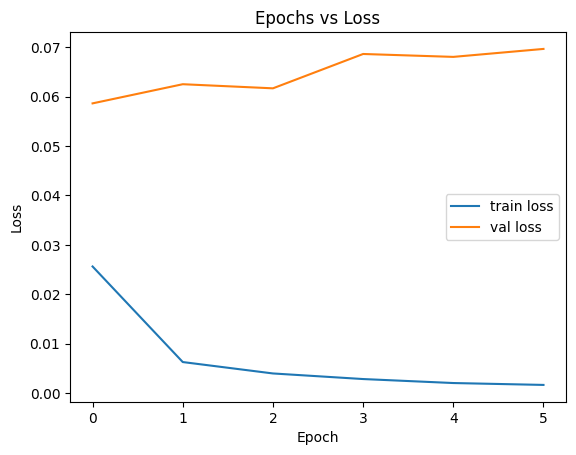

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(qat_history.history["loss"], label="train loss")
plt.plot(qat_history.history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.legend()
plt.show()


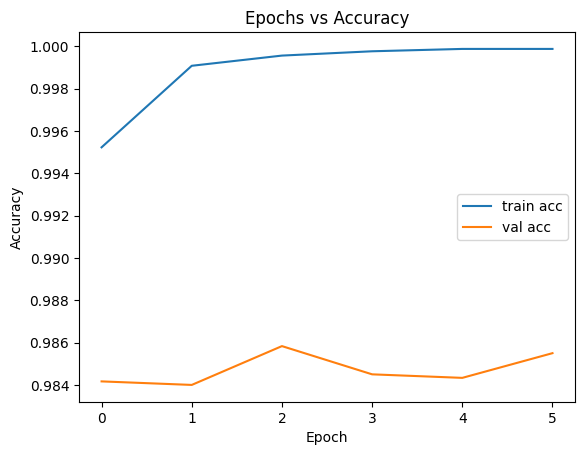

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(qat_history.history["accuracy"], label="train acc")
plt.plot(qat_history.history["val_accuracy"], label="val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epochs vs Accuracy")
plt.legend()
plt.show()


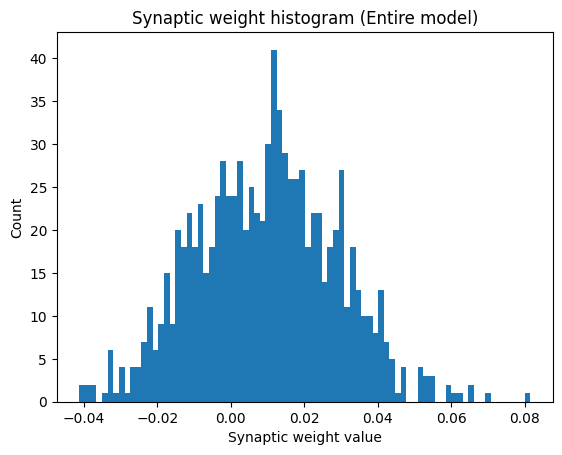

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

all_w = []

for layer in qat_model.layers:
    inner = getattr(layer, "layer", None)
    if inner is None:
        continue
    if not isinstance(inner, keras.layers.Dense):
        continue

    w = inner.get_weights()[0]  # kernel
    all_w.append(w.reshape(-1))

all_w = np.concatenate(all_w)

plt.figure()
plt.hist(all_w, bins=80)
plt.xlabel("Synaptic weight value")
plt.ylabel("Count")
plt.title("Synaptic weight histogram (Entire model)")
plt.show()


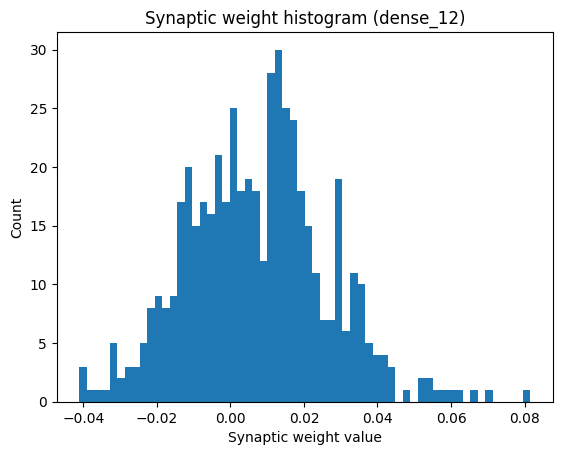

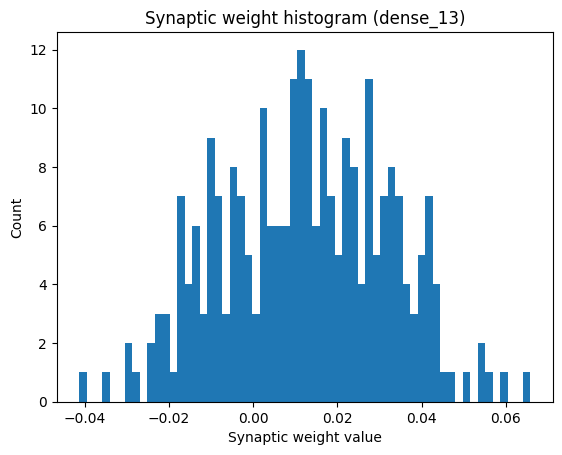

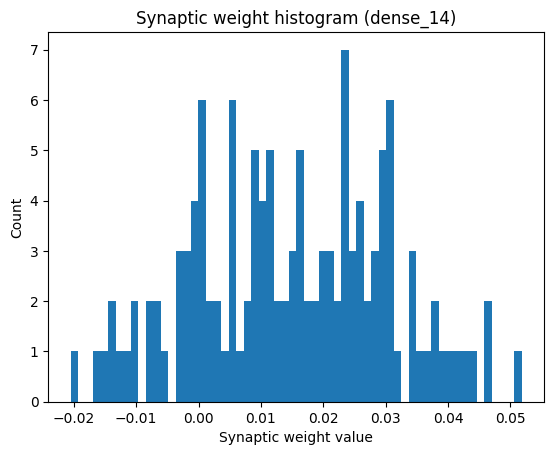

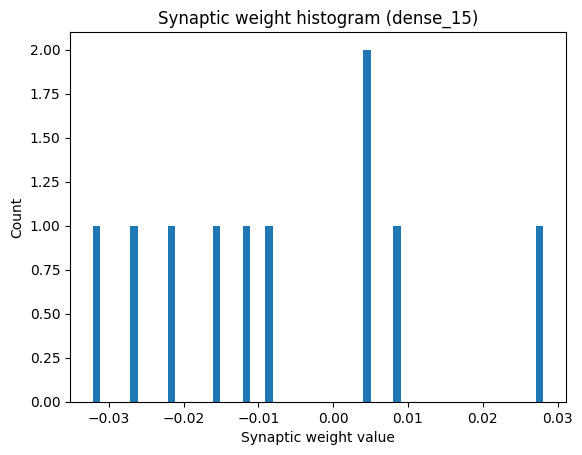

In [ ]:
import matplotlib.pyplot as plt

for layer in qat_model.layers:
    inner = getattr(layer, "layer", None)
    if inner is None:
        continue
    if not isinstance(inner, keras.layers.Dense):
        continue

    w = inner.get_weights()[0]  # kernel

    plt.figure()
    plt.hist(w.reshape(-1), bins=60)
    plt.xlabel("Synaptic weight value")
    plt.ylabel("Count")
    plt.title(f"Synaptic weight histogram ({inner.name})")
    plt.show()
